In [2]:
%load_ext autoreload
%autoreload 2

import sys
HOME='/srv/home/christinedk/wp_internship/'
sys.path.append(HOME + 'collaboration/')
from config import TEMPLATES

In [3]:
import pandas as pd
import numpy as np
from time  import time
import matplotlib.pylab as plt
from pyspark.sql.functions import udf, col, explode, regexp_replace, first, mean, size, count, collect_list

from data_export import getTemplatesRegexRelaibility, getTemplatesRegex

In [4]:
TEMPLATES = ['weasel','peacock','autobiography','advert','fanpov']
outputHDFS = 'page_history'
!hadoop fs -mkdir $outputHDFS

mkdir: `page_history': File exists


# Get full edit history of pages and editors

In [43]:
## Read back revisions with template
revisions_with_template = spark.read.parquet(outputHDFS+'/templates.parquet')

In [44]:
## Select subset of mediawiki history containing all page titles with revisions

pages_templates_subset = revisions_with_template.select('page_title').distinct()
pages_templates_subset.createOrReplaceTempView('pages_templates_subset')

mediawiki_history_subset =  spark.sql('''
        SELECT w.page_title,w.page_id,w.event_user_is_anonymous,w.event_user_id
        FROM wmf.mediawiki_history w
        WHERE w.snapshot ="2020-09" and w.wiki_db ="enwiki" AND  
        w.event_entity = 'revision' AND w.page_title IN (
                    SELECT page_title FROM pages_templates_subset)                   
        ''')
mediawiki_history_subset.cache()
mediawiki_history_subset.createOrReplaceTempView('mediawiki_history_subset')

In [189]:
## Get full histories of these pages *and* all editors who revised them

for template in ['autobiography']:#,'fanpov','advert']:#TEMPLATES:
    try:
        outputHDFS = 'page_history'
        t1 = time()
        print(template)
        df = revisions_with_template.where(revisions_with_template['col']==template) # 
        df.cache()
        t2 = time()
        print('read table, done',t2-t1)
        t1 = time()
        page_ids = df.select('page_title').distinct()
        page_ids.createOrReplaceTempView('tmp_page_ids')
        users = spark.sql('''
        SELECT DISTINCT w.event_user_id
        FROM mediawiki_history_subset w 
        WHERE w.page_title IN (SELECT page_title FROM tmp_page_ids)
        AND w.event_user_is_anonymous = 0
        ''') 
        users.createOrReplaceTempView('tmp_users')
        t1 = time()
        print('found users, done',t2-t1)

        print('extracting user histories')
        t1 = time()
        user_histories =  spark.sql('''
        SELECT w.event_user_id, 
        SIZE(w.event_user_is_bot_by) is_bot
        FROM wmf.mediawiki_history w
        WHERE w.snapshot ="2020-09" and w.wiki_db ="enwiki" AND  
        w.event_entity = 'revision' 
        AND w.event_user_id IN (SELECT event_user_id FROM tmp_users)
        ''') #think about anonymous users, order by, deleted revision
        user_histories.cache()
        t2=time()
        print('-----',t2-t1)
    
    except Exception as e:
        print('error',e)

autobiography
read table, done 0.1176140308380127
found users, done -0.06753659248352051
extracting user histories
----- 0.06150054931640625


In [190]:
user_counts = user_histories.groupby('event_user_id').count().toPandas()

In [191]:
counts = user_counts.sort_values(by='count',ascending=False)['count'].values

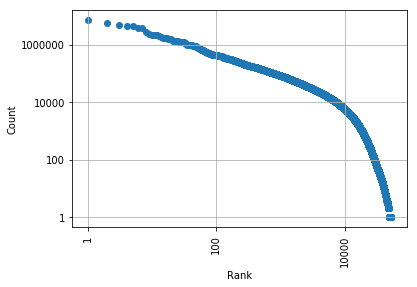

In [196]:
plt.ticklabel_format(style='sci', axis='both',scilimits=(0,0))
import numpy as np

plt.scatter(np.log10(np.arange(len(counts))+1),np.log10(counts))
yy=plt.yticks(np.arange(0,8,2),10**np.arange(0,8,2))
xx=plt.xticks(np.arange(0,6,2),10**np.arange(0,6,2),rotation=90)
plt.grid()
plt.ylabel('Count')
plt.xlabel('Rank')
plt.show()

In [121]:
bots = user_histories.groupby('event_user_id').agg(first('size(event_user_is_bot_by)')).toPandas()

In [127]:
bots['is_bot'] = (bots['first(size(event_user_is_bot_by), false)']>0).astype(int)

In [129]:
bots['is_bot'].mean()

0.009464801581268055

In [132]:
user_histories = user_histories.withColumn("bot",(col('size(event_user_is_bot_by)')>0).cast("long"))

In [133]:
user_histories.select(F.mean(col('bot'))).show()

+-------------------+
|           avg(bot)|
+-------------------+
|0.21892918015453197|
+-------------------+



In [134]:
user_histories.select(F.sum(col('bot'))).show()

+---------+
| sum(bot)|
+---------+
|106672366|
+---------+



# Exclude bots

In [45]:
## Get full histories of these pages *and* all editors who revised them
## without bots

tag_users = {}

for template in TEMPLATES:
    try:
        outputHDFS = 'page_history'
        t1 = time()
        print(template)
        df = revisions_with_template.where(revisions_with_template['col']==template) # 
        df.cache()
        t2 = time()
        print('read table, done',t2-t1)
        t1 = time()
        page_ids = df.select('page_title').distinct()
        page_ids.createOrReplaceTempView('tmp_page_ids')
        users = spark.sql('''
        SELECT DISTINCT w.event_user_id
        FROM mediawiki_history_subset w 
        WHERE w.page_title IN (SELECT page_title FROM tmp_page_ids)
        AND w.event_user_is_anonymous = 0
        ''') 
        users.createOrReplaceTempView('tmp_users')
        t1 = time()
        print('found users, done',t2-t1)

        print('extracting user histories')
        t1 = time()
        user_histories =  spark.sql('''
        SELECT w.event_user_id, COUNT(w.event_user_id)
        FROM wmf.mediawiki_history w
        WHERE w.snapshot ="2020-09" and w.wiki_db ="enwiki" AND  
        w.event_entity = 'revision' 
        AND w.event_user_id IN (SELECT event_user_id FROM tmp_users)
        AND SIZE(w.event_user_is_bot_by) = 0
        GROUP BY w.event_user_id
        ''') #think about anonymous users, order by, deleted revision
        user_histories.cache()
        tag_users[template] = user_histories.toPandas()
        t2=time()
        print('-----',t2-t1)
    
    except Exception as e:
        print('error',e)

weasel
read table, done 0.00712275505065918
found users, done -0.030977249145507812
extracting user histories
----- 172.21308541297913
peacock
read table, done 0.008663654327392578
found users, done -0.04720473289489746
extracting user histories
----- 48.20999026298523
autobiography
read table, done 0.005991458892822266
found users, done -0.029736757278442383
extracting user histories
----- 44.23067378997803
advert
read table, done 0.006903886795043945
found users, done -0.03308582305908203
extracting user histories
----- 42.23804521560669
fanpov
read table, done 0.007677555084228516
found users, done -0.04140734672546387
extracting user histories
----- 43.13214039802551


weasel
peacock
autobiography
advert
fanpov


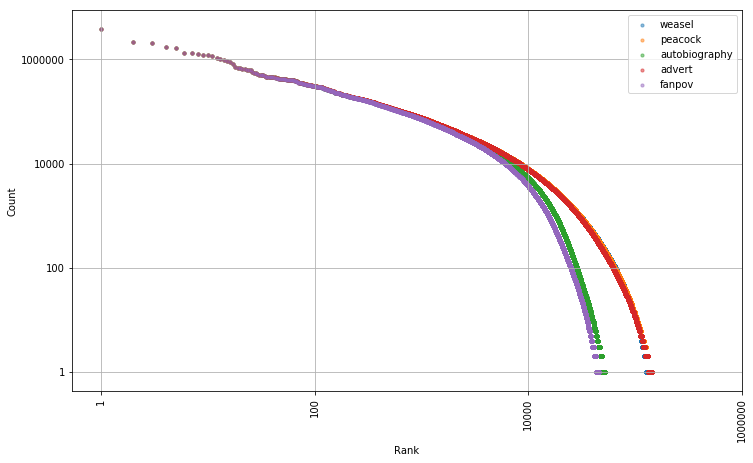

In [44]:
plt.figure(figsize=[12,7])

for template in TEMPLATES:
    print(template)
    counts = tag_users[template].sort_values(by='count(event_user_id)',ascending=False)['count(event_user_id)'].values

    plt.scatter(np.log10(np.arange(len(counts))+1),np.log10(counts),label=template,alpha=0.5,s=10)
    yy=plt.yticks(np.arange(0,8,2),10**np.arange(0,8,2))
    xx=plt.xticks(np.arange(0,8,2),10**np.arange(0,8,2),rotation=90)
plt.grid()
plt.ylabel('Count')
plt.xlabel('Rank')
plt.legend()
plt.show()

In [185]:
for i in range(5):
    print(TEMPLATES[i].upper())
    df_ref = tag_users[TEMPLATES[i]]
    ref_users = set(df_ref.event_user_id.values)
    print('Num users: {}'.format(len(ref_users)))
    for j in range(5):
        if i!=j:
            comp_users = set(tag_users[TEMPLATES[j]].event_user_id.values)
            users_overlap = ref_users.intersection(comp_users)
            n_users_overlap = len(users_overlap)
            print('\t+ {}:'.format(TEMPLATES[j]))
            print('\t\tUsers overlap: {} Frac: {}'.format(n_users_overlap,np.round(n_users_overlap/len(df_ref),2)))
            
            
            n_edits_overlap = df_ref[df_ref.event_user_id.isin(users_overlap)]['count(event_user_id)'].sum()
            print('\t\tEdits overlap: {} Frac: {}'.format(n_edits_overlap,np.round(n_edits_overlap/(df_ref['count(event_user_id)'].sum()),3)))
            
        else:
            pass
    print()


WEASEL
Num users: 135483
	+ peacock:
		Users overlap: 51627 Frac: 0.38
		Edits overlap: 420225115 Frac: 0.931
	+ autobiography:
		Users overlap: 20440 Frac: 0.15
		Edits overlap: 363399052 Frac: 0.805
	+ advert:
		Users overlap: 44477 Frac: 0.33
		Edits overlap: 414430423 Frac: 0.918
	+ fanpov:
		Users overlap: 19972 Frac: 0.15
		Edits overlap: 335196215 Frac: 0.743

PEACOCK
Num users: 144522
	+ weasel:
		Users overlap: 51627 Frac: 0.36
		Edits overlap: 420225115 Frac: 0.924
	+ autobiography:
		Users overlap: 23460 Frac: 0.16
		Edits overlap: 366852352 Frac: 0.807
	+ advert:
		Users overlap: 48739 Frac: 0.34
		Edits overlap: 418372708 Frac: 0.92
	+ fanpov:
		Users overlap: 24976 Frac: 0.17
		Edits overlap: 338854548 Frac: 0.745

AUTOBIOGRAPHY
Num users: 52117
	+ weasel:
		Users overlap: 20440 Frac: 0.39
		Edits overlap: 363399052 Frac: 0.956
	+ peacock:
		Users overlap: 23460 Frac: 0.45
		Edits overlap: 366852352 Frac: 0.965
	+ advert:
		Users overlap: 24309 Frac: 0.47
		Edits overlap:

In [ ]:
# Insight: Unique editors do not overlap to a great extent, but the edits of the overlapping editors are substantial
# >> Makes sense to process them as one graph

# Export full histories for users (not bots)

In [ ]:
# Note: this exports histories for all users separately per tag, which is not super useful 
# given the above information: there is a lot of overlap between them. 
# The next section exports them all together

In [ ]:
## Read back revisions with template
revisions_with_template = spark.read.parquet(outputHDFS+'/templates.parquet')

In [ ]:
## Select subset of mediawiki history containing all page titles with revisions

pages_templates_subset = revisions_with_template.select('page_title').distinct()
pages_templates_subset.createOrReplaceTempView('pages_templates_subset')

mediawiki_history_subset =  spark.sql('''
        SELECT w.page_title,w.page_id,w.event_user_is_anonymous,w.event_user_id
        FROM wmf.mediawiki_history w
        WHERE w.snapshot ="2020-09" and w.wiki_db ="enwiki" AND  
        w.event_entity = 'revision' AND w.page_title IN (
                    SELECT page_title FROM pages_templates_subset)                   
        ''')
mediawiki_history_subset.cache()
mediawiki_history_subset.createOrReplaceTempView('mediawiki_history_subset')

In [43]:
for template in TEMPLATES:
    try:
        outputHDFS = 'user_history'
        t1 = time()
        print(template)
        df = revisions_with_template.where(revisions_with_template['col']==template) # 
        df.cache()
        t2 = time()
        print('read table, done',t2-t1)
        t1 = time()
        page_ids = df.select('page_title').distinct()
        page_ids.createOrReplaceTempView('tmp_page_ids')
        users = spark.sql('''
        SELECT DISTINCT w.event_user_id
        FROM mediawiki_history_subset w 
        WHERE w.page_title IN (SELECT page_title FROM tmp_page_ids)
        AND w.event_user_is_anonymous = 0
        ''') 
        users.createOrReplaceTempView('tmp_users')
        t1 = time()
        print('found users, done',t2-t1)
        
        
        print('extracting user histories')
        t1 = time()
        user_histories =  spark.sql('''
        SELECT w.event_user_text, w.event_timestamp, w.page_title,w.page_id,w.page_namespace,
        w.revision_id, w.revision_is_identity_reverted, revision_is_identity_revert,
        w.revision_minor_edit, w.revision_text_bytes, 
        w.revision_first_identity_reverting_revision_id,
        w.event_user_id,w.event_user_registration_timestamp, 
        SIZE(w.event_user_groups) as num_groups,
        SIZE(w.event_user_blocks_historical) as num_blocks_historical, 
        SIZE(w.event_user_blocks) as num_curr_blocks
        FROM wmf.mediawiki_history w
        
        WHERE w.snapshot ="2020-09" and w.wiki_db ="enwiki" AND  
        w.event_entity = 'revision' 
        AND w.event_user_id IN (SELECT event_user_id FROM tmp_users) 
        AND SIZE(w.event_user_is_bot_by) = 0
        ORDER BY w.event_user_id
        ''') 
        user_histories.cache()
        user_histories.repartition(1).write.format('json').save(outputHDFS+'/'+template,mode='overwrite')
        t2 = time()
        print('save table, done',t2-t1)
        user_ids = user_histories.select('event_user_id').distinct()
        print('number of users: ', user_ids.count())
        t1 = time()   
        templateout = template.replace(' ','_')
        !hadoop fs -text "$outputHDFS/$template/*" > $outputHDFS-$template-meta-info.json
        t2 = time()
        print('-----',t2-t1)
    
    except Exception as e:
        print('error',e)

weasel
read table, done 0.09238576889038086
found users, done -0.06015896797180176
extracting user histories
save table, done 1434.7125420570374
number of users:  135483
text: `user_history/weasel/_temporary': Is a directory
21/03/08 21:32:35 INFO compress.CodecPool: Got brand-new decompressor [.snappy]
----- 492.7768256664276
peacock
read table, done 0.08702683448791504
found users, done -0.030692338943481445
extracting user histories
save table, done 1873.1532759666443
number of users:  144522
21/03/08 22:12:04 INFO compress.CodecPool: Got brand-new decompressor [.snappy]
----- 475.9412546157837
autobiography
read table, done 0.09299492835998535
found users, done -0.04932570457458496
extracting user histories
save table, done 1375.2048921585083
number of users:  52117
21/03/08 22:42:57 INFO compress.CodecPool: Got brand-new decompressor [.snappy]
----- 466.0584509372711
advert
read table, done 0.08124065399169922
found users, done -0.03620791435241699
extracting user histories
save t

# Editor-editor features

In [47]:
## Read back revisions with template
revisions_with_template = spark.read.parquet(outputHDFS+'/templates.parquet')

In [48]:
## Select subset of mediawiki history containing all page titles with revisions

pages_templates_subset = revisions_with_template.select('page_title').distinct()
pages_templates_subset.createOrReplaceTempView('pages_templates_subset')

users =  spark.sql('''
        SELECT DISTINCT w.event_user_id
        FROM wmf.mediawiki_history w
        WHERE w.snapshot ="2020-09" and w.wiki_db ="enwiki" AND  
        w.event_entity = 'revision' AND w.page_title IN (
        SELECT page_title FROM pages_templates_subset)                   
        ''')
users.cache()
users.createOrReplaceTempView('tmp_users')

In [49]:
print('extracting user histories')
t1 = time()
user_histories =  spark.sql('''
SELECT w.event_user_text, w.event_timestamp, w.page_title,w.page_id,w.page_namespace,
w.revision_id, w.revision_is_identity_reverted, revision_is_identity_revert,
w.revision_minor_edit, w.revision_text_bytes, 
w.revision_first_identity_reverting_revision_id,
w.event_user_id,w.event_user_registration_timestamp, 
SIZE(w.event_user_groups) as num_groups,
SIZE(w.event_user_blocks_historical) as num_blocks_historical, 
SIZE(w.event_user_blocks) as num_curr_blocks
FROM wmf.mediawiki_history w

WHERE w.snapshot ="2020-09" and w.wiki_db ="enwiki" AND  
w.event_entity = 'revision' 
AND w.event_user_id IN (SELECT event_user_id FROM tmp_users) 
AND SIZE(w.event_user_is_bot_by) = 0
ORDER BY w.event_user_id
''') 
#user_histories.cache()
user_histories.write.parquet('editors/user_histories.parquet',mode='overwrite')

extracting user histories


In [ ]:
# Read back

In [50]:
user_histories = spark.read.parquet('editors/user_histories.parquet')
user_histories.count()

515325018

In [27]:
# editor past interactions (all namespaces)
## nb: have to deal with only history pre tag.....
user_pages = user_histories.select(user_histories.page_id,user_histories.event_user_id,
                                   user_histories.revision_id,user_histories.page_namespace)\
                            .groupBy("page_id","event_user_id")\
                            .agg(count("revision_id").alias("revisions_count"),
                                 first("page_namespace").alias('page_namespace'))

user_pages.cache()
user_pages.write.parquet('user_history/user_pages.parquet',mode='overwrite')

self_join_df = user_pages.toDF(*[c + '_r' for c in user_pages.columns])
editor_interactions = user_pages.join(self_join_df,[user_pages.page_id == self_join_df.page_id_r,
                       user_pages.event_user_id != self_join_df.event_user_id_r]).drop('page_id_r')

all_interactions = editor_interactions.groupby('event_user_id','event_user_id_r').agg(collect_list("page_id").alias('common_pages'))
all_interactions = all_interactions.withColumn('num_common_pages',size(col('common_pages')))
all_interactions.cache()

DataFrame[event_user_id: bigint, event_user_id_r: bigint, common_pages: array<bigint>]

In [32]:
all_interactions.count()

4170111470

In [12]:
num_interactions = all_interactions.withColumn('num_interactions',size(col('common_pages'))) 

In [13]:
# editor past interactions (only articles)

user_articles = user_pages.where(user_pages.page_namespace==0)
self_join_df = user_articles.toDF(*[c + '_r' for c in user_articles.columns])
user_articles = user_articles.join(self_join_df,[user_articles.page_id == self_join_df.page_id_r,
                       user_articles.event_user_id != self_join_df.event_user_id_r]).drop('page_id_r')

article_coedits = user_articles.groupby('event_user_id','event_user_id_r').agg(collect_list("page_id").alias('common_pages'))

In [14]:
article_coedits.show(10)

+-------------+---------------+--------------------+
|event_user_id|event_user_id_r|        common_pages|
+-------------+---------------+--------------------+
|            1|             94|[6115, 13694, 231...|
|            1|            185|[12250, 6429, 152...|
|            1|            328|[18933600, 18884,...|
|            1|           2597|[72634, 142690, 4...|
|            1|           3278|[89314, 13694, 18...|
|            1|           3808|[69238, 10258, 18...|
|            1|           8155|[19984080, 469133...|
|            1|           9218|[23745, 32917, 52...|
|            1|          13933|[6097297, 6021, 1...|
|            1|          14063|[822093, 39675, 6...|
+-------------+---------------+--------------------+
only showing top 10 rows



In [15]:
num_coedits = article_coedits.withColumn('num_coedits',size(col('common_pages'))) 

In [ ]:
# editor-editor features (directed)

In [ ]:
# ratio of co-edited articles to all edited articles

coedit_ratio = all_interactions.groupby('event_user_id').agg(size('event_user_id')/sum('num_common_pages'))

In [19]:
# look at a better way to do this so that we do not need to re-do the big join

from pyspark.sql.functions import countDistinct, count

article_concentration_ratio = user_histories.groupby('page_id')\
                    .agg(count("revision_id")/countDistinct("event_user_id")\
                    .alias('concentration_ratio'))

# Super users

In [54]:
user_counts = user_histories.groupby('event_user_id')\
            .agg(count('revision_id').alias('num_edits'))

In [56]:
user_counts.show(10)

+-------------+---------+
|event_user_id|num_edits|
+-------------+---------+
|      1046101|       18|
|      1048422|     9757|
|      1056492|      109|
|      1057624|      108|
|      1069572|      259|
|      1071743|       26|
|      1085213|     8181|
|      1093605|       43|
|      1099373|      339|
|      1104766|      640|
+-------------+---------+
only showing top 10 rows



In [58]:
user_counts = user_counts.toPandas().sort_values(by='num_edits',ascending=False)

In [62]:
user_counts.num_edits.sum()

515325018

In [63]:
user_counts

,event_user_id,num_edits
149466,753665,3769334
79327,205121,2165569
247344,754619,2070336
232423,82835,1725958
89433,196446,1672421
187717,9784415,1342522
178952,7852030,1331224
315334,1951353,1256876
55664,1276024,1232088
380911,508734,1210633


# Using shorter histories

In [79]:
import dateutil 
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import min, max

In [65]:
template = 'fanpov'

tags_added = pd.read_csv('/srv/home/christinedk/wp_internship/data/tag_events/{}_tag_added.csv'.format(template))

In [81]:
tag_date = dateutil.parser.parse(tags_added.event_timestamp.min())
start_date = tag_date - relativedelta(years=1)

In [85]:
user_histories = user_histories.withColumn('event_timestamp',
                                           to_timestamp(col('event_timestamp')))

In [104]:
user_histories_1year = user_histories.filter(col("event_timestamp").between(start_date,tag_date))
user_histories_1year.count()

13502993

In [106]:
# editor past interactions (all namespaces)
## nb: have to deal with only history pre tag.....
user_pages = user_histories_1year.select(user_histories_1year.page_id,user_histories_1year.event_user_id,
                                   user_histories_1year.revision_id,user_histories_1year.page_namespace)\
                            .groupBy("page_id","event_user_id")\
                            .agg(count("revision_id").alias("revisions_count"),
                                 first("page_namespace").alias('page_namespace'))

user_pages.cache()

self_join_df = user_pages.toDF(*[c + '_r' for c in user_pages.columns])
editor_interactions = user_pages.join(self_join_df,[user_pages.page_id == self_join_df.page_id_r,
                       user_pages.event_user_id != self_join_df.event_user_id_r]).drop('page_id_r')

all_interactions = editor_interactions.groupby('event_user_id','event_user_id_r').agg(collect_list("page_id").alias('common_pages'))
all_interactions = all_interactions.withColumn('num_common_pages',size(col('common_pages')))
all_interactions.cache()

DataFrame[event_user_id: bigint, event_user_id_r: bigint, common_pages: array<bigint>, num_common_pages: int]

In [107]:
all_interactions.count()

41794294